In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import vis
from data import load_raw_data, clean_raw_data, prepare_base_features, extract_ticker

In [16]:
df_raw = load_raw_data(rootpath = os.path.dirname(os.getcwd()))
df_clean = clean_raw_data(df_raw)
ticker = 'AAPL'
df_clean_ticker = extract_ticker(df_clean, ticker, requiredrecords=500, write=False) # datapath=datapat
df = prepare_base_features(df_clean_ticker)
df = df.sort_values('Date')

rootpath: /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting
reading raw data from: /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting/data/world-stock-prices-daily-updating/World-Stock-Prices-Dataset.csv
Extracting for ticker: AAPL
Extracted sample shape: (500, 5)


In [17]:
df.index

DatetimeIndex(['2023-06-28', '2023-06-29', '2023-06-30', '2023-07-03',
               '2023-07-05', '2023-07-06', '2023-07-07', '2023-07-10',
               '2023-07-11', '2023-07-12',
               ...
               '2025-06-20', '2025-06-23', '2025-06-24', '2025-06-25',
               '2025-06-26', '2025-06-27', '2025-06-30', '2025-07-01',
               '2025-07-02', '2025-07-03'],
              dtype='datetime64[ns]', name='Date', length=500, freq=None)

In [18]:
closing_price = df['Close']
# closing_price.index = pd.date_range(start="1996", end="2008", freq="Y")
# convert the index to periods
closing_price.index = closing_price.index.to_period("D")
closing_price.index

PeriodIndex(['2023-06-28', '2023-06-29', '2023-06-30', '2023-07-03',
             '2023-07-05', '2023-07-06', '2023-07-07', '2023-07-10',
             '2023-07-11', '2023-07-12',
             ...
             '2025-06-20', '2025-06-23', '2025-06-24', '2025-06-25',
             '2025-06-26', '2025-06-27', '2025-06-30', '2025-07-01',
             '2025-07-02', '2025-07-03'],
            dtype='period[D]', name='Date', length=500)

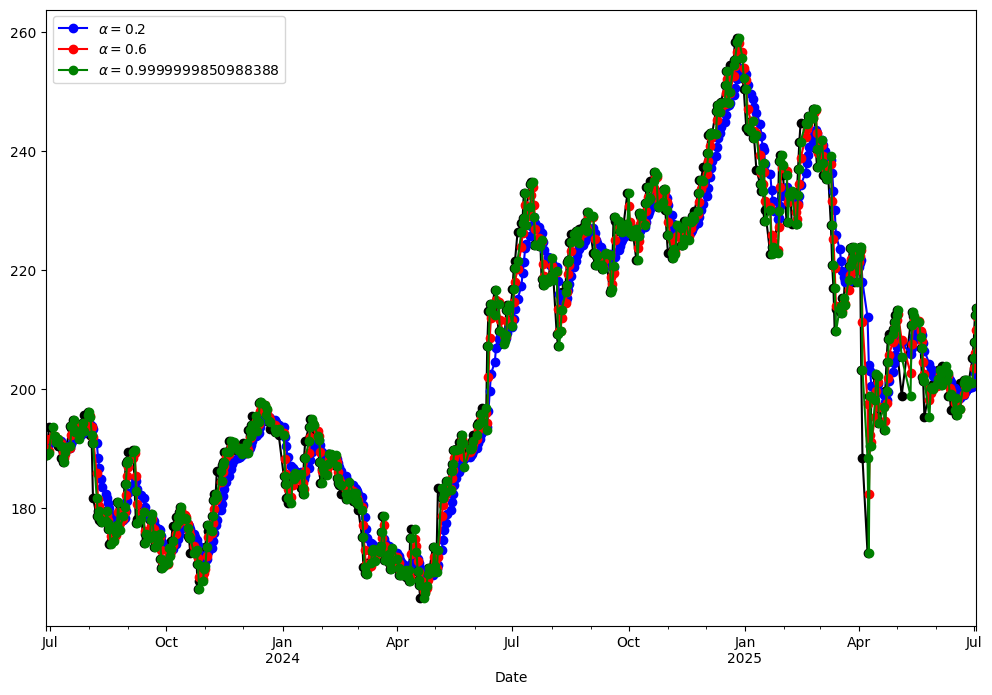

In [21]:

fit1 = SimpleExpSmoothing(closing_price, initialization_method="heuristic").fit(
    smoothing_level=0.2, optimized=False
)
fcast1 = fit1.forecast(3).rename(r"$\alpha=0.2$")
fit2 = SimpleExpSmoothing(closing_price, initialization_method="heuristic").fit(
    smoothing_level=0.6, optimized=False
)
fcast2 = fit2.forecast(3).rename(r"$\alpha=0.6$")
fit3 = SimpleExpSmoothing(closing_price, initialization_method="estimated").fit()
fcast3 = fit3.forecast(3).rename(r"$\alpha=%s$" % fit3.model.params["smoothing_level"])

plt.figure(figsize=(12, 8))
closing_price.plot(marker="o", color="black")
plt.plot(fit1.fittedvalues, marker="o", color="blue")
(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(fit2.fittedvalues, marker="o", color="red")
(line2,) = plt.plot(fcast2, marker="o", color="red")
plt.plot(fit3.fittedvalues, marker="o", color="green")
(line3,) = plt.plot(fcast3, marker="o", color="green")
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])